In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss

In [36]:
# read in data
imb = pd.read_csv('../data/imbalance_de.csv', header=None)

In [37]:
imb.head()

,0,1,2
0,2013-12-31 23:00:00,707.500,156.36
1,2013-12-31 23:15:00,966.296,81.23
2,2013-12-31 23:30:00,1018.984,104.01
3,2013-12-31 23:45:00,867.940,60.51
4,2014-01-01 00:00:00,1738.004,239.03


In [38]:
# drop column '2'
imb.drop(2, axis=1, inplace=True)

In [39]:
# rename columns
imb.rename(columns={0: 'timestamp', 1: 'imbalance_price'}, inplace=True)

In [40]:
# convert timestamp to datetime object
imb['timestamp'] = pd.to_datetime(imb['timestamp'])

In [41]:
# reset index -> Datetime index
imb = imb.set_index('timestamp')

In [42]:
imb.head()

,imbalance_price
timestamp,
2013-12-31 23:00:00,707.500
2013-12-31 23:15:00,966.296
2013-12-31 23:30:00,1018.984
2013-12-31 23:45:00,867.940
2014-01-01 00:00:00,1738.004


In [43]:
# aggregate data on hourly timesteps and interpolate missing values
def fill_missing(data):
    data = data.resample('1H').median()
    data = data.interpolate(method='time', limit_direction='both')
    return data

In [44]:
imb_filled = fill_missing(imb)

## Plots - Imbalance Price

<AxesSubplot:xlabel='timestamp'>

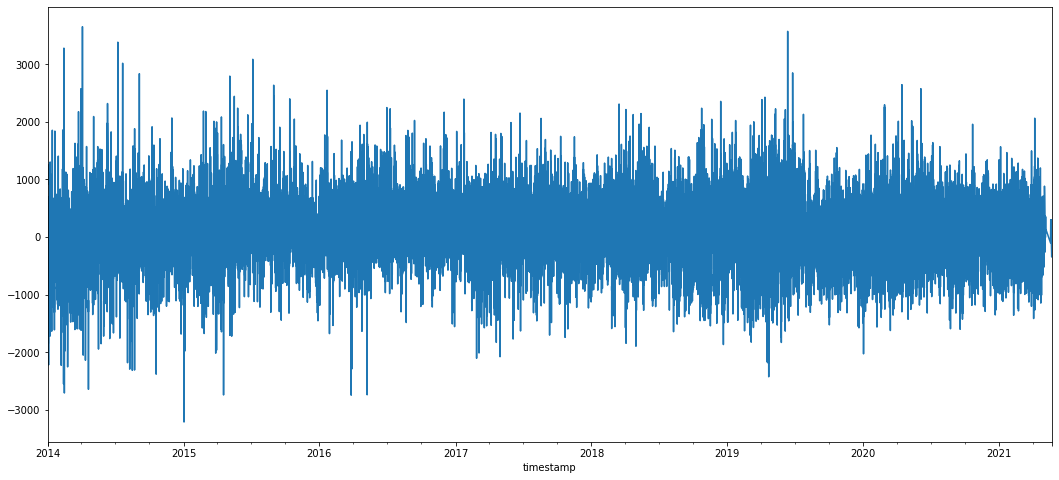

In [45]:
# plot the orginal timeseries
plt.figure(figsize=(18,8))
imb_filled['imbalance_price'].plot()

## Check for stationarity

In [46]:
# reduce data set
imb_19_21 = imb_filled[imb_filled.index > '2018-12-31 23:00:00']

In [47]:
print ('Results of KPSS Test:')
kpsstest = kpss(imb_19_21['imbalance_price'], regression='c', nlags='legacy')
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(imb_19_21['imbalance_price'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                            'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of KPSS Test:
Test Statistic            0.938074
p-value                   0.010000
Lags Used                46.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:


/Users/laurenthartmann/neuefische/capstone_energy/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic                -1.570569e+01
p-value                        1.378857e-28
#Lags Used                     4.600000e+01
Number of Observations Used    2.090400e+04
Critical Value (1%)           -3.430663e+00
Critical Value (5%)           -2.861678e+00
Critical Value (10%)          -2.566844e+00
dtype: float64


### Results stationarity tests:
Both tests must be rejected based on the p-value. There is no clear evidence for stationarity or non-stationarity.

### Rolling mean and rolling standard deviation

In [48]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=24).mean()
    rolling_std = timeseries.rolling(window=24).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

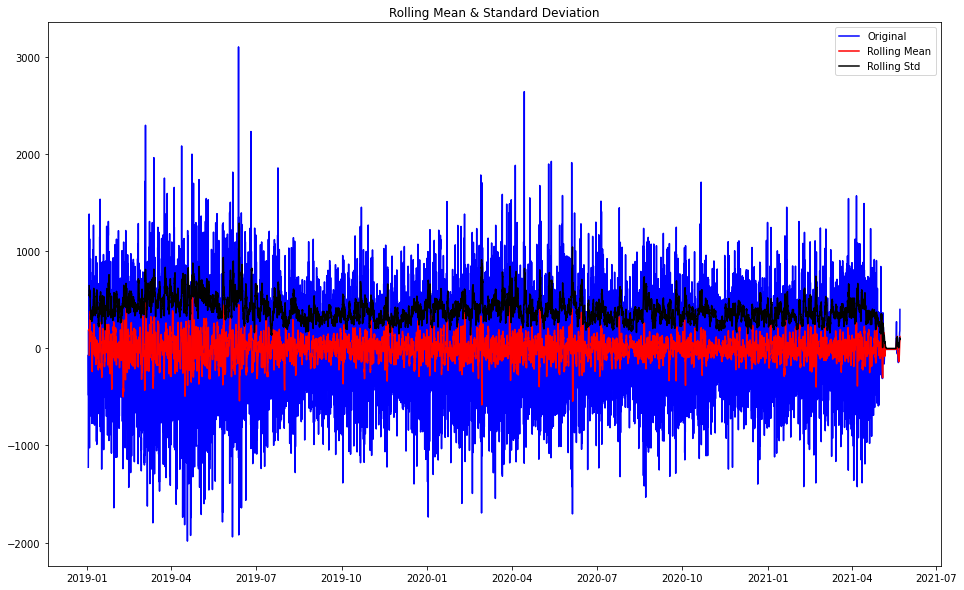

In [49]:
plt.figure(figsize=(16, 10))

rolling_mean = imb_19_21.rolling(window=24).mean()
imb_19_21_minus_mean = imb_19_21 - rolling_mean
imb_19_21_minus_mean.dropna(inplace=True)
get_stationarity(imb_19_21_minus_mean)

### Timeseries decomposition

#### Start: 2019

In [50]:
imb_19_21.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


In [51]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

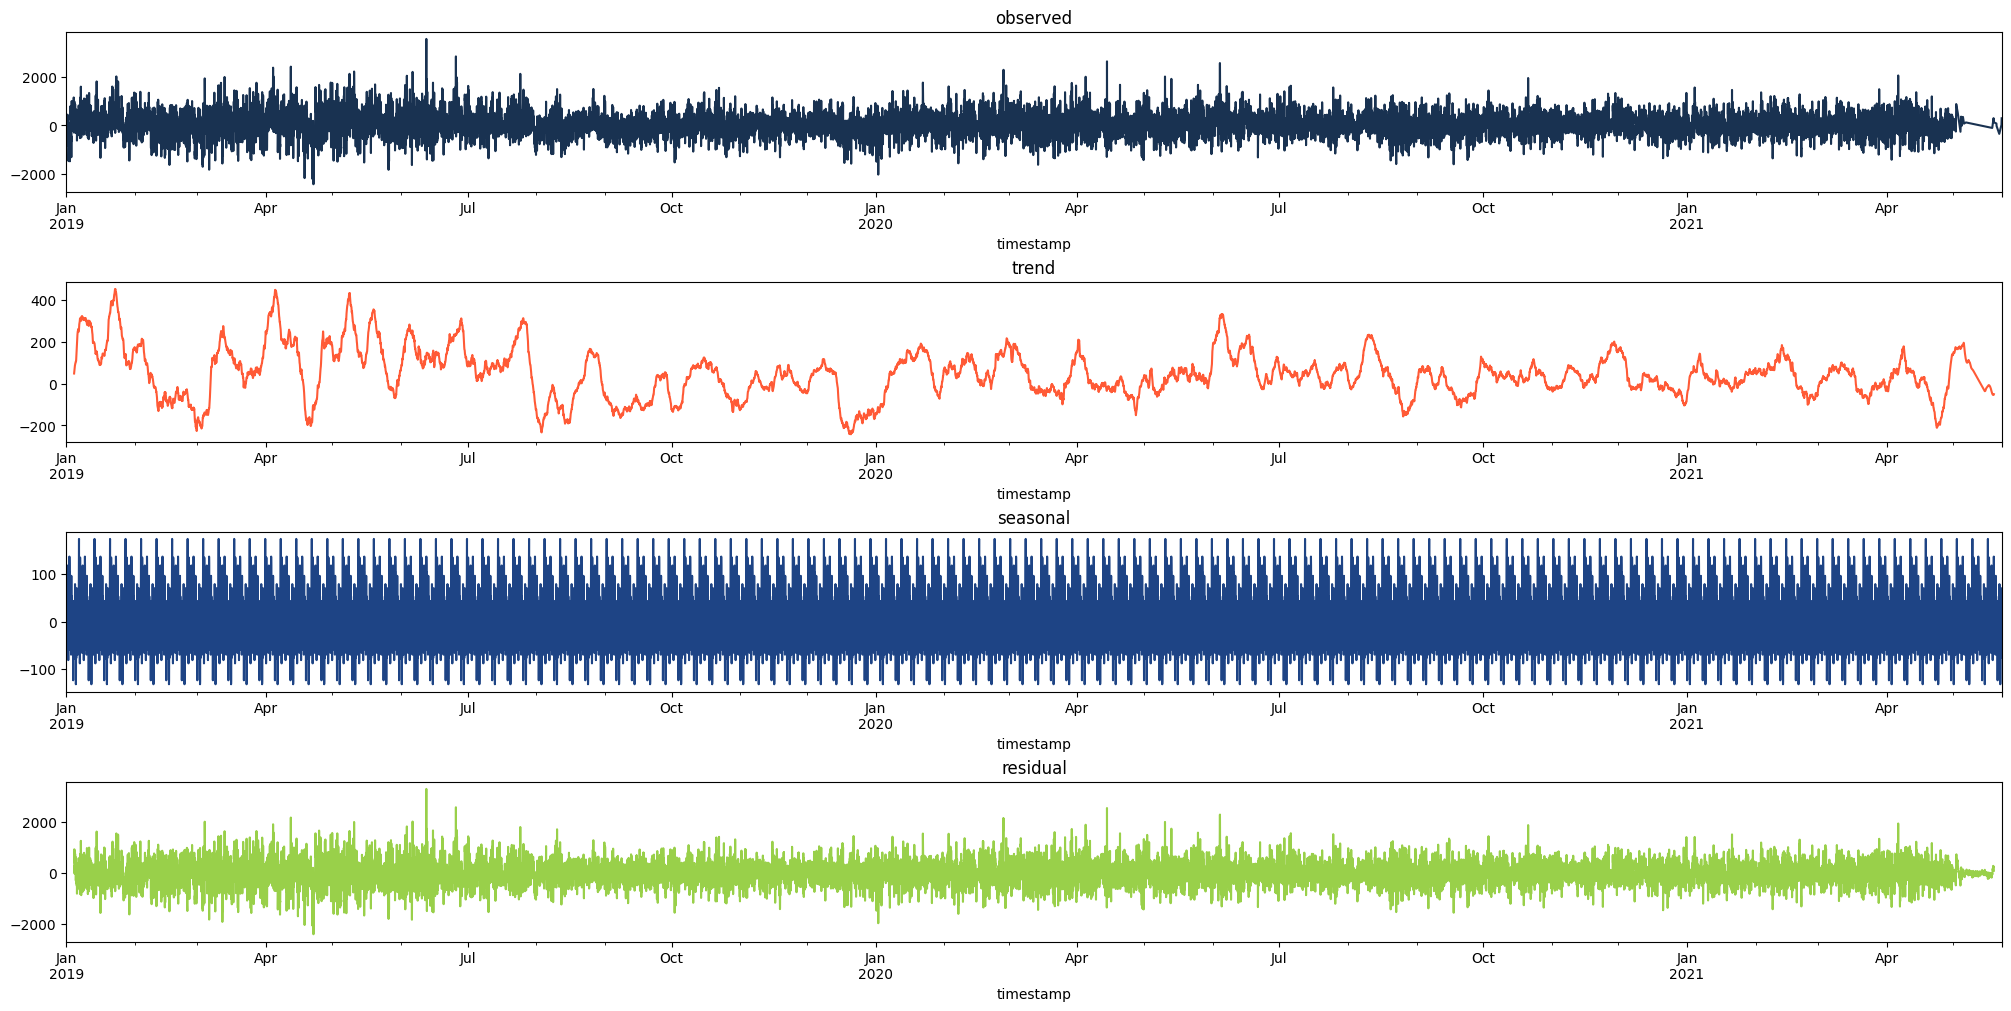

In [52]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=imb_19_21['imbalance_price'], 
                                   model='additive',
                                   period=168)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

#### Start: 2020

In [53]:
imb_20_21 = imb_19_21[imb_19_21.index > '2019-12-31 23:00:00']

In [54]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

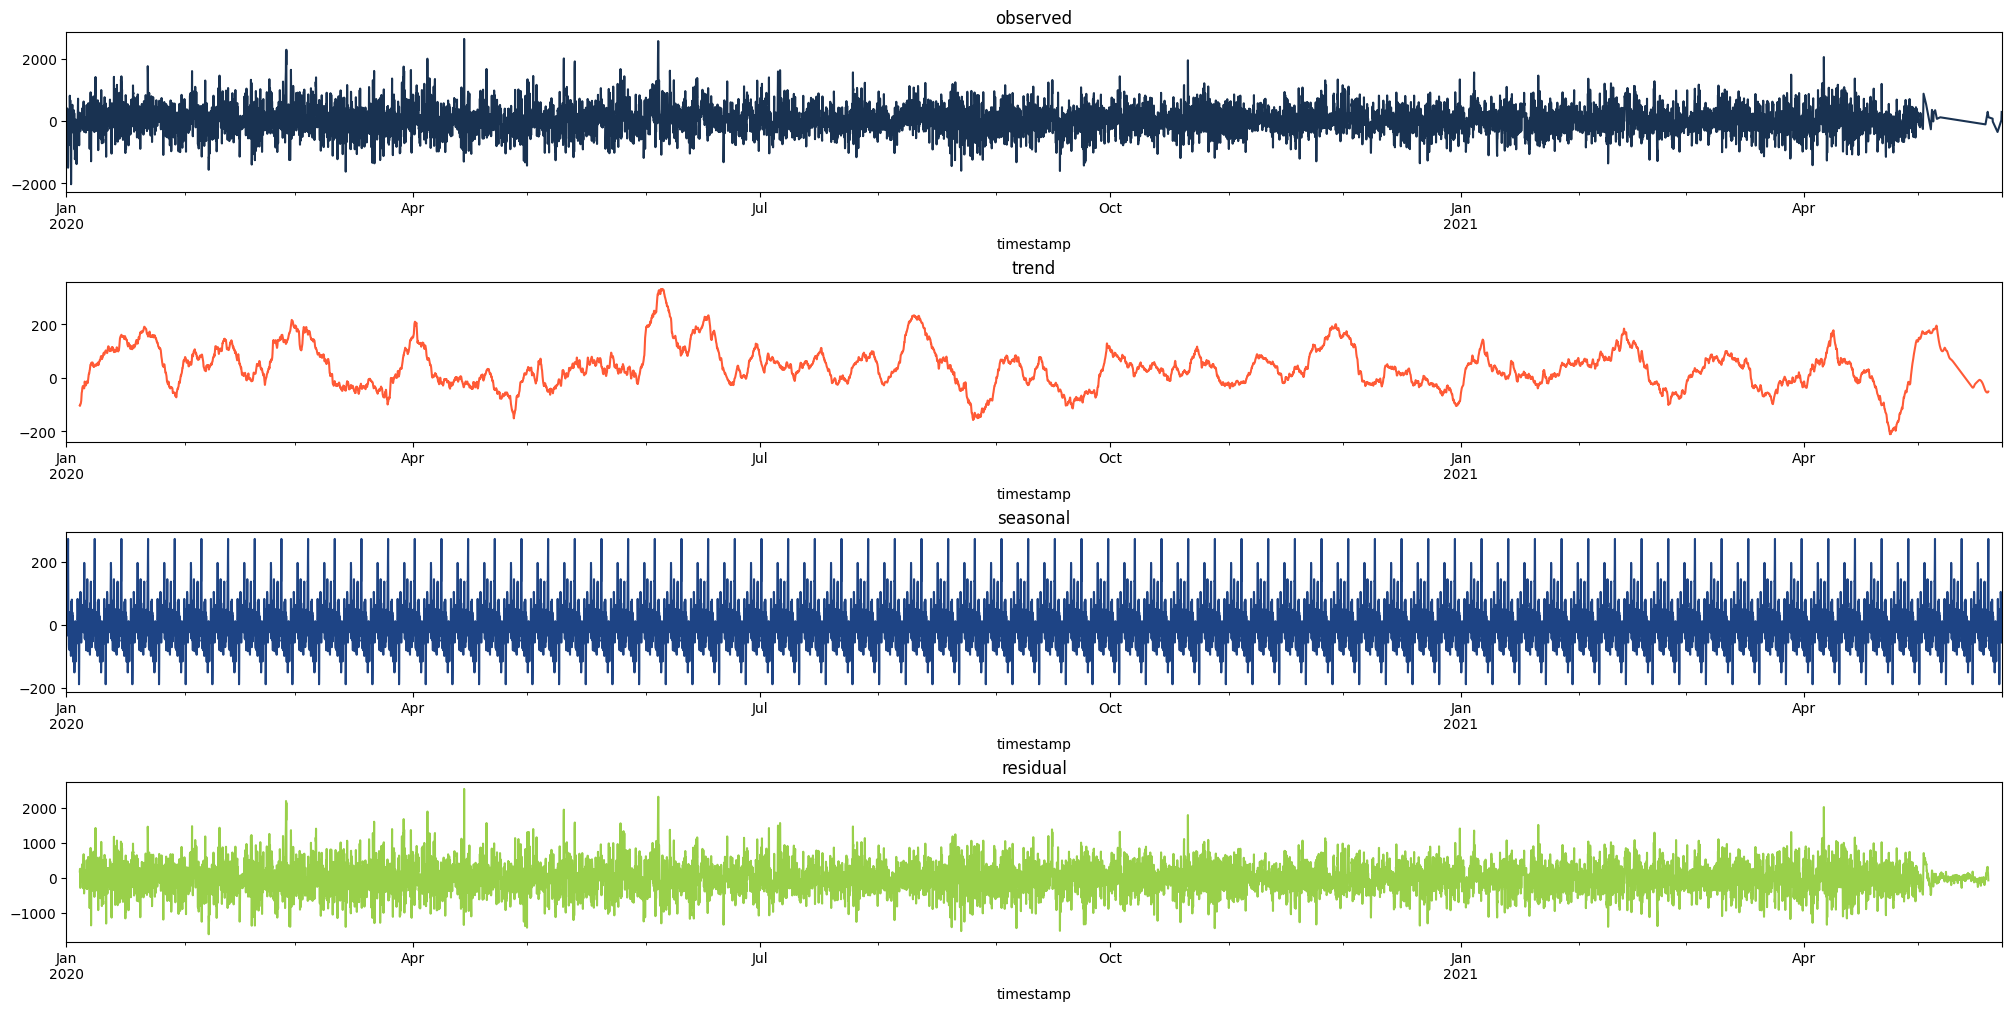

In [55]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=imb_20_21['imbalance_price'], 
                                   model='additive',
                                   period=168)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

#### 2021

In [56]:
imb_21 = imb_19_21[imb_19_21.index > '2020-12-31 23:00:00']

In [57]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

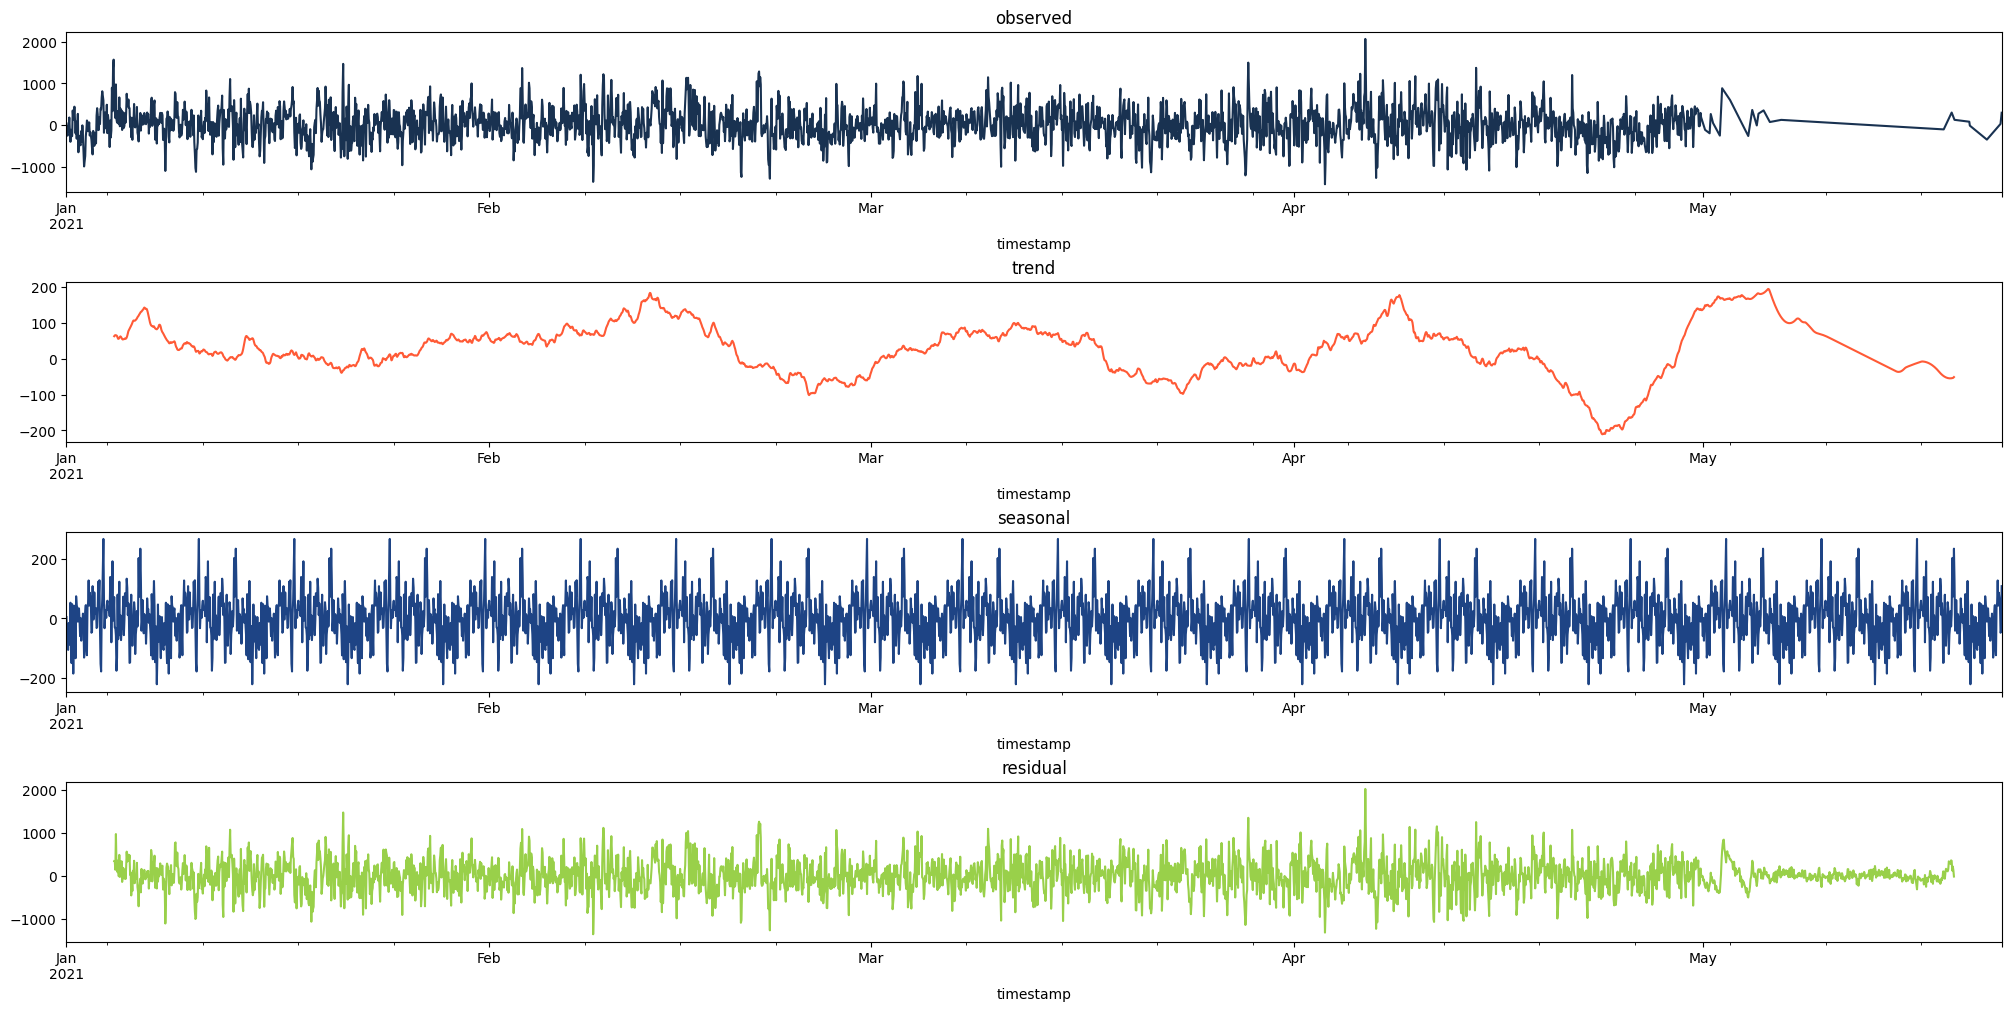

In [58]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=imb_21['imbalance_price'], 
                                   model='additive',
                                   period=168)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

#### 1 Month

In [59]:
imb_1m = imb_19_21[(imb_19_21.index > '2020-12-31 23:00:00') & (imb_19_21.index <= '2021-01-31 23:00:00')]

In [60]:
# Define plotting parameters and custom color palette 
cmaps_hex = ['#193251','#FF5A36','#1E4485', '#99D04A','#FF5A36', '#DB6668']
#sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100

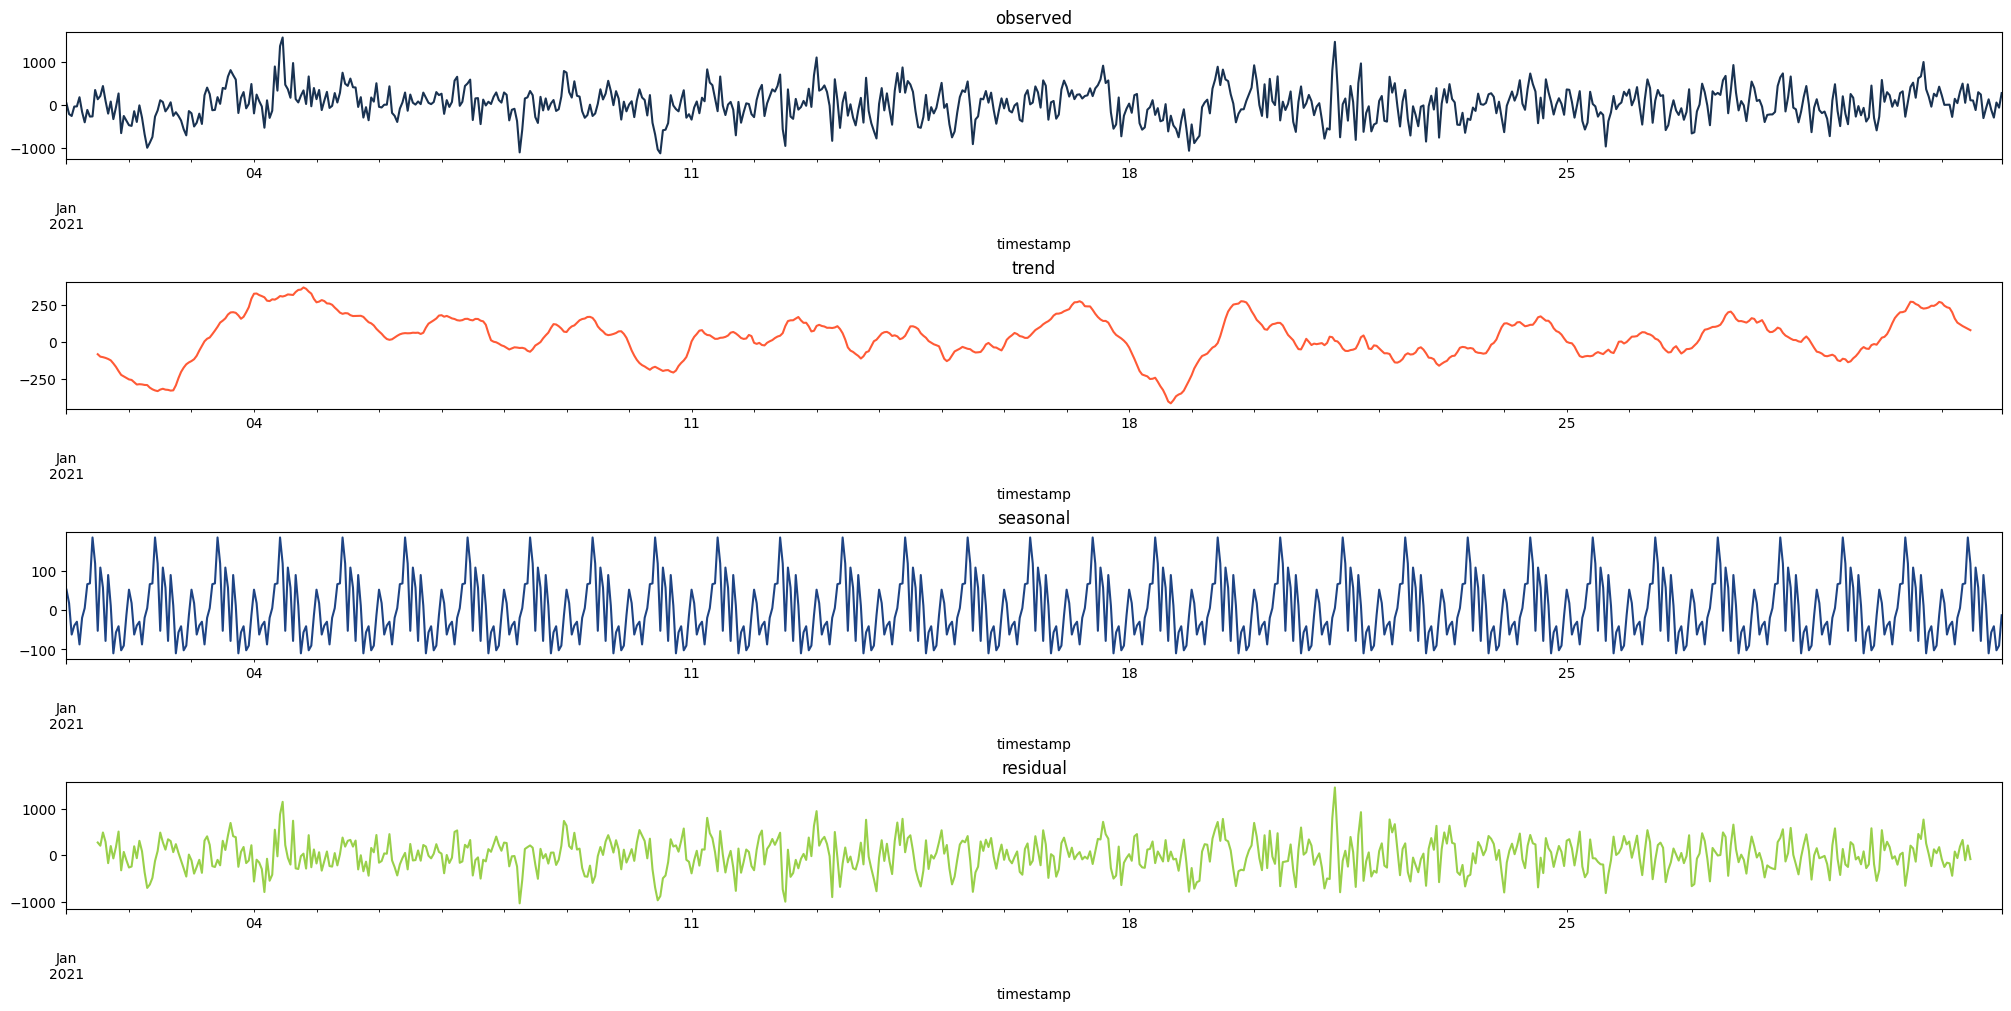

In [61]:
# Check decomposition of trend, seasonality and residue of original time series
decomposition = seasonal_decompose(x=imb_1m['imbalance_price'], 
                                   model='additive',
                                   period=24)


fig, ax = plt.subplots(4, 1, figsize=(12, 12), constrained_layout=True)
decomposition.observed.plot(c=sns_c[0], ax=ax[0])
ax[0].set(title='observed')
decomposition.trend.plot(c=sns_c[1], ax=ax[1])
ax[1].set(title='trend')
decomposition.seasonal.plot(c=sns_c[2], ax=ax[2])
ax[2].set(title='seasonal')
decomposition.resid.plot(c=sns_c[3], ax=ax[3])
ax[3].set(title='residual')
fig.set_size_inches(20, 10);

### CSV export

In [67]:
# drop last month (may)
imb_19_21 = imb_19_21[imb_19_21.index < '2021-05-01 00:00:00']
imb_20_21 = imb_20_21[imb_20_21.index < '2021-05-01 00:00:00']
imb_21 = imb_21[imb_21.index < '2021-05-01 00:00:00']

In [68]:
imb_19_21.to_csv("../data/imbalance_1h_2019.csv")
imb_20_21.to_csv("../data/imbalance_1h_2020.csv")
imb_21.to_csv("../data/imbalance_1h_2021.csv")